# RMSD Restraint testing

In this notebook, we will perform some basic tests of our prototype RMSD restraints in sire.

In [1]:
import sire as sr
import matplotlib.pyplot as plt
import numpy as np
import openmm as mm
import openmm.app as app
import openmm.unit as unit
from sys import stdout
# import pytest

In [2]:
def obtain_rmsd(mols, selection_str="atomname CA, C, N"):

    rmsd_df = mols.trajectory().rmsd(selection_str, to_pandas=True)

    return rmsd_df['rmsd'].to_numpy()

## Python source code

https://github.com/BenTanYK/sire/blob/ac4542c135d2325b94e63896e06be4c155b07f67/src/sire/restraints/_restraints.py#L760

In [ ]:
def rmsd(mols, atoms, ref=None, k=None, r0=None, name=None, map=None):
    """
    Create a set of RMSD restraints for the atoms specified in
    'atoms' that are contained in the container 'mols', using the
    passed values of 'k' and flat-bottom potential
    well-width 'r0' for the restraints. Note that 'k' values
    correspond to half the force constants for the harmonic
    restraints, because the harmonic restraint energy is defined as
    k*(rmsd - r0)**2 (hence the force is defined as 2*(rmsd - r0)).

    The RMSD calculation is perfomed by default using the position
    of mols. Optionally, a different state of the system can be
    supplied as a reference by passing the 'ref' argument.

    If 'r0' is not specified, then a simple harmonic restraint
    is used.

    If 'k' is not specified, then a default of 150 kcal mol-1 A-2
    will be used.

    Parameters
    ----------
    mols : sire.system._system.System
        The system containing the atoms.

    atoms : SireMol::Selector<SireMol::Atom>
        The atoms to restrain.

    ref : sire.system._system.System
        The system from which the reference positions for the RMSD calculation
        are extracted from. If None, this will default to the current
        state of mols.    

    k : str or SireUnits::Dimension::GeneralUnit or, optional
        The force constant for the RMSD restraints.
        If None, this will default to 150 kcal mol-1 A-2.
        Default is None.

    r0 : str or SireUnits::Dimension::GeneralUnit, optional
        The width of the flat bottom restraint. If None, this is zero
        and a simple harmonic restraint is used.
        Default is None.

    Returns
    -------
    RMSDRestraints : SireMM::RMSDRestraints
        A container of RMSD restraints, where the first restraint is
        the RMSDRestraint created. The RMSD restraint created can be
        extracted with RMSDRestraints[0].
    """
    from .. import u
    from ..base import create_map
    from ..mm import RMSDRestraint, RMSDRestraints

    map = create_map(map)

    if k is None:
        k = u("150 kcal mol-1 A-2")
    else:
        k = u(k)

    if r0 is None:
        r0 = u("0")
    else:
        r0 = u(r0)

    atoms = _to_atoms(mols, atoms)
    mols = mols.atoms()

    if name is None:
        restraints = RMSDRestraints()
    else:
        restraints = RMSDRestraints(name=name)

    # Set default reference positions to mols
    if ref is None:
        ref = mols
    else:
        try:
            ref = ref.atoms()
        except AttributeError:
            raise TypeError("The reference state must be a complete system.")

    # Generate list of all positions as reference for RMSD calculation
    ref_pos = ref.atoms().property("coordinates")

    restraints.add(RMSDRestraint(mols.find(atoms), ref_pos, k, r0))

    return restraints

## Tutorial

The tutorial for RMSD restraints can be found here: 

https://github.com/BenTanYK/sire/blob/feature_rmsd_restraints/doc/source/tutorial/part06/03_restraints.rst#rmsd-restraints

## Basic tests (included in sire tests directory)

In [3]:
def test_default_rmsd_restraints_setup(ala_mols):
    """Tests that rmsd restraints can be set up correctly with default parameters."""
    mols = ala_mols.clone()
    restraints = sr.restraints.rmsd(mols=mols, atoms=[0, 1, 2, 3, 4])
    assert restraints.num_restraints() == 1
    assert restraints[0].atoms() == [0, 1, 2, 3, 4]
    assert restraints[0].k().value() == 150.0
    assert restraints[0].r0().value() == 0.0

def test_rmsd_restraint_custom_k(ala_mols):
    """Tests that rmsd restraints can be set up correctly with custom k."""
    mols = ala_mols.clone()
    restraints = sr.restraints.rmsd(
        mols=mols, atoms=[0, 1, 2, 3, 4], k="10 kcal mol-1 A-2"
    )
    assert restraints.num_restraints() == 1
    assert restraints[0].atoms() == [0, 1, 2, 3, 4]
    assert restraints[0].k().value() == 10.0
    assert restraints[0].r0().value() == 0.0

def test_rmsd_restraint_custom_k_and_r0(ala_mols):
    """Tests that rmsd restraints can be set up correctly with custom k and r0."""
    mols = ala_mols.clone()
    restraints = sr.restraints.rmsd(
        mols=mols, atoms="atomname CA, C, N", k="10 kcal mol-1 A-2", r0="1 A"
    )
    assert restraints.num_restraints() == 1
    assert restraints[0].k().value() == 10.0
    assert restraints[0].r0().value() == 1.0

def test_rmsd_restraint_custom_k_and_r0_and_ref(ala_mols):
    """Tests that rmsd restraints can be set up correctly with custom k, r0 and reference state."""
    mols = ala_mols.clone()
    ref = mols.clone().minimisation().run().commit()
    restraints = sr.restraints.rmsd(
        mols=mols, atoms="atomname CA, C, N", k="10 kcal mol-1 A-2", r0="1 A", ref=ref
    )
    assert restraints.num_restraints() == 1
    assert mols.count() == ref.count()
    assert restraints[0].k().value() == 10.0
    assert restraints[0].r0().value() == 1.0

ala_mols = sr.load(['structures/ala.top', 'structures/ala.crd'])
test_default_rmsd_restraints_setup(ala_mols)
test_rmsd_restraint_custom_k(ala_mols)
test_rmsd_restraint_custom_k_and_r0(ala_mols)
test_rmsd_restraint_custom_k_and_r0_and_ref(ala_mols)

Extract property     98%       0.5 s 4184.0 its / s          


### Measuring the RMSD of a restrained structure

Apply the restraint potential $\rho \cdot k \cdot \text{step}(\delta) \cdot \delta^2; \quad \delta = (\text{rmsd} - \text{r}_\circ) $, where $\text{r}_\circ$ = 0.5 Å

#### DCAF16

Calculate RMSD                 5.0 s   99.5 its / s          


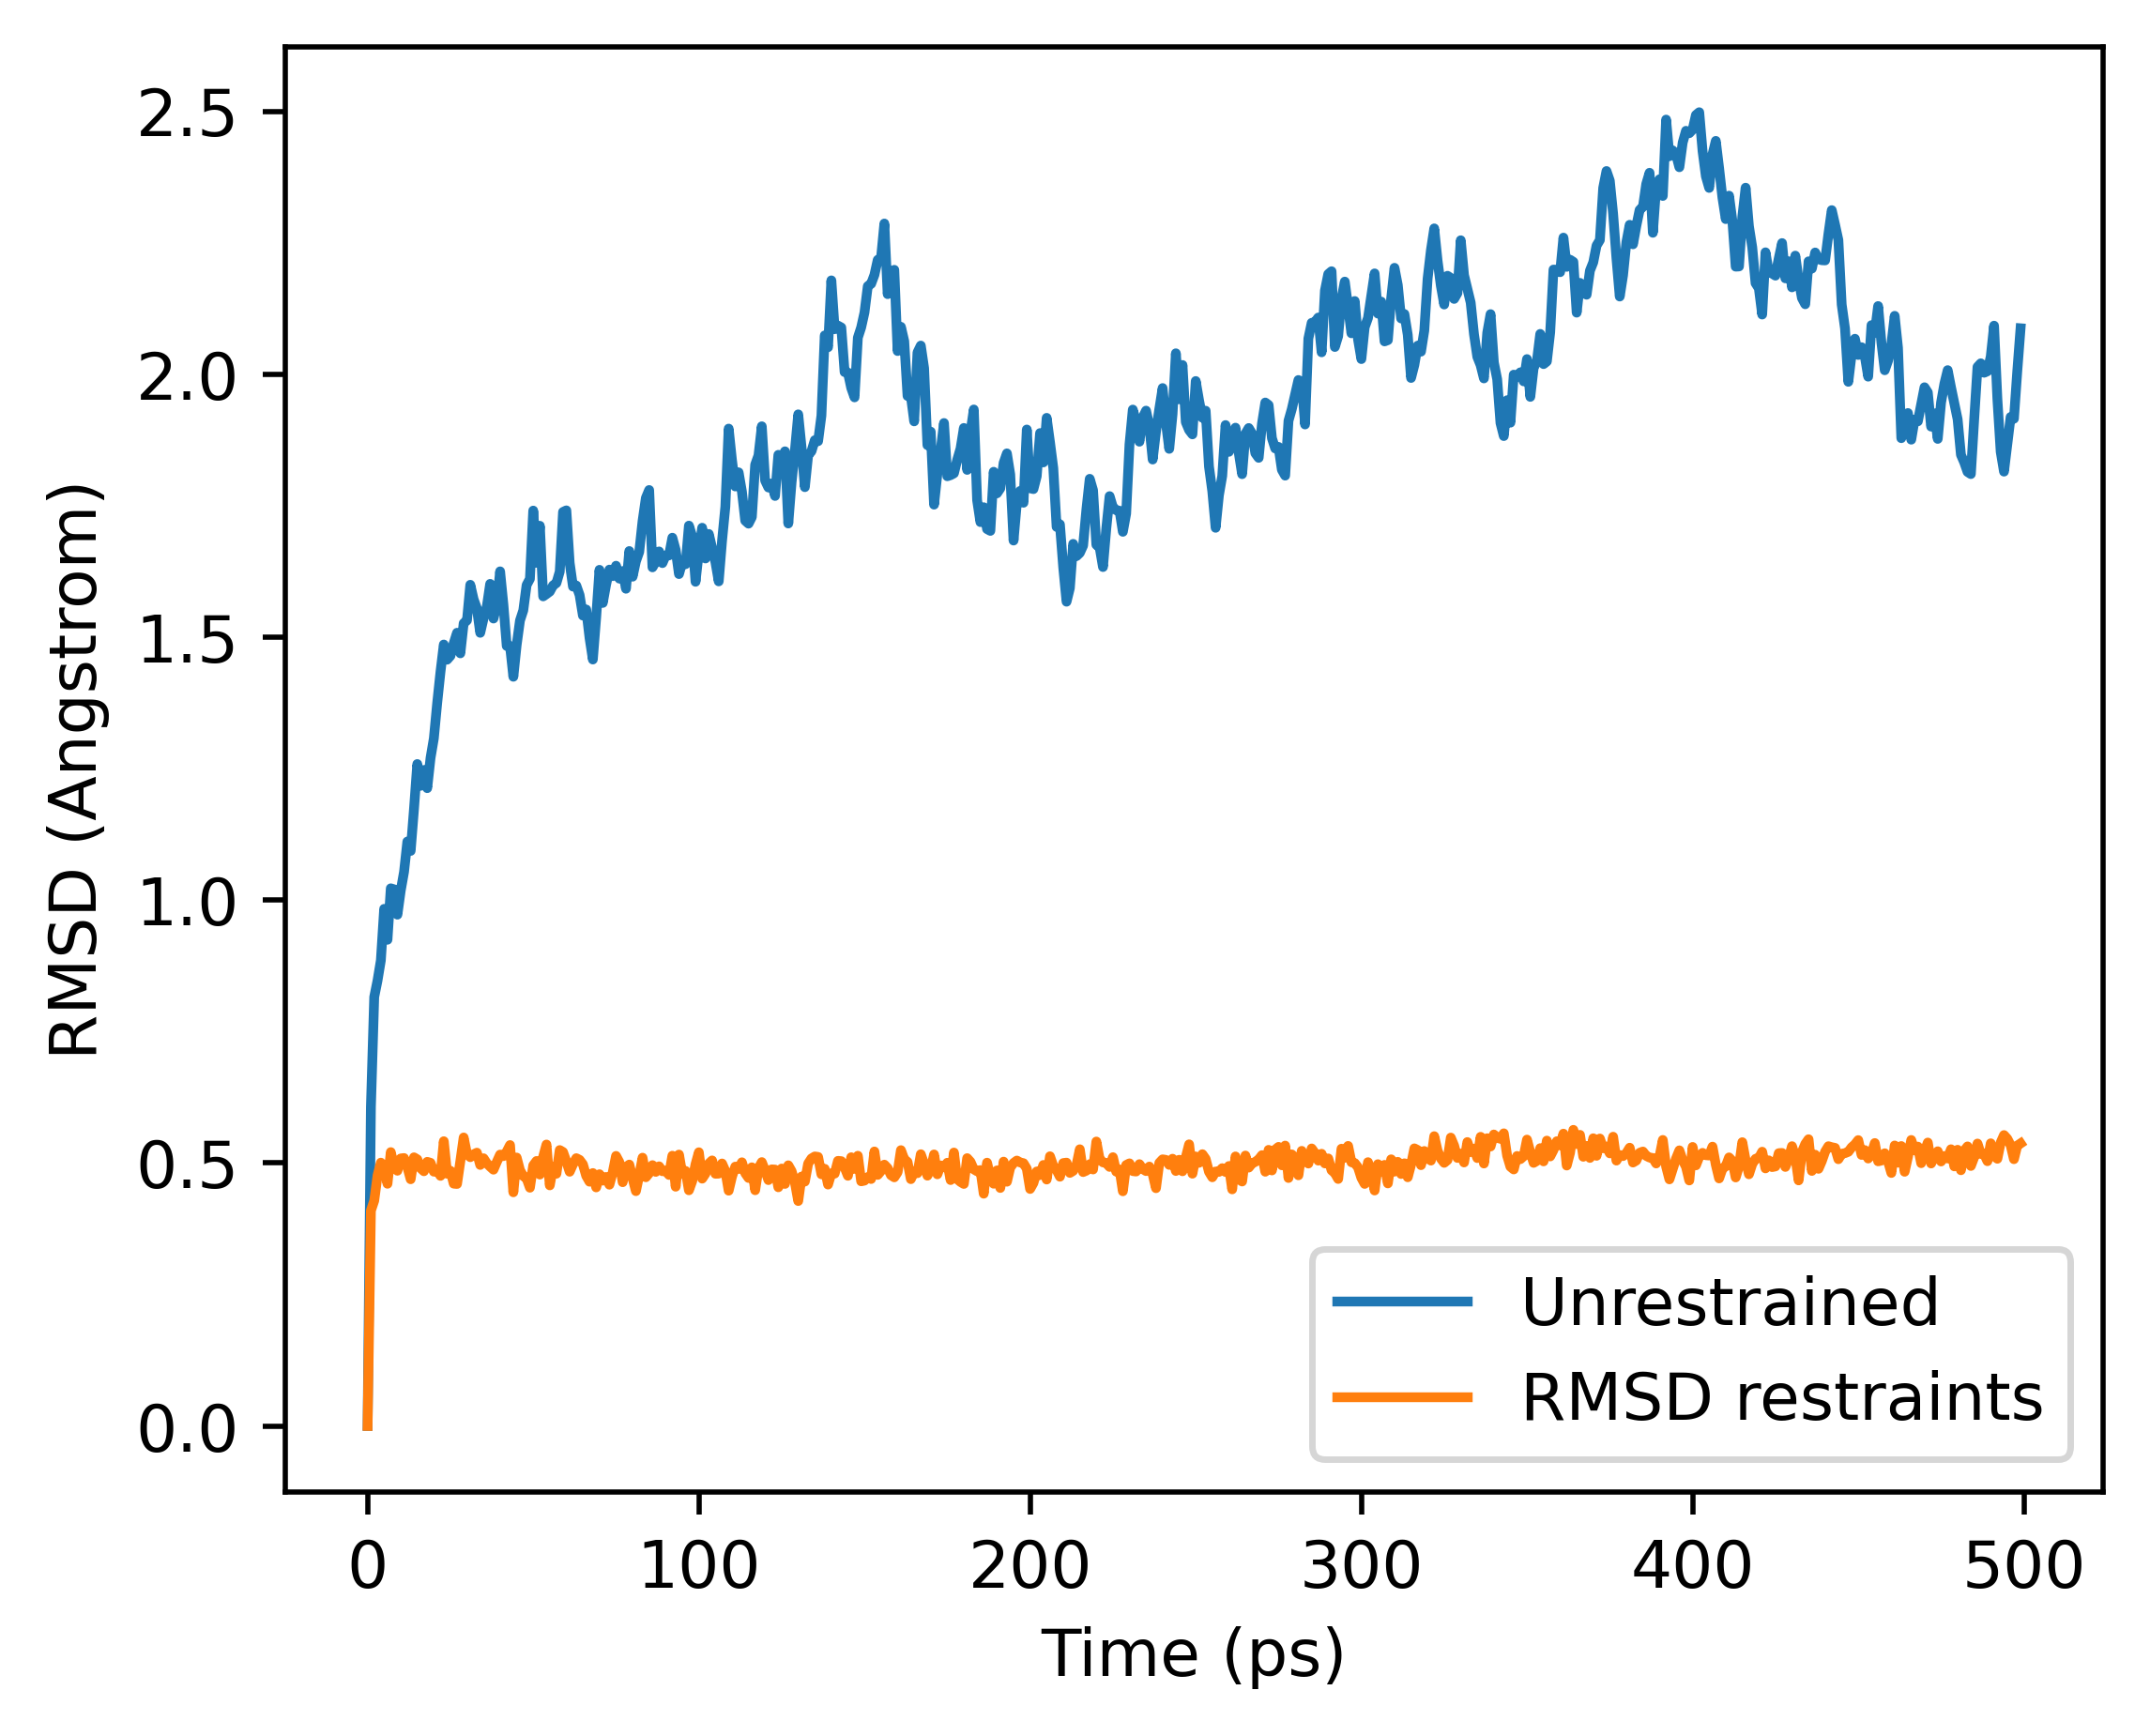

In [7]:
# Run unrestrained MD
mols = sr.load(['structures/DCAF16.prmtop', 'structures/DCAF16.inpcrd'])
mols = mols.minimisation().run().commit()
d = mols.dynamics(timestep="4fs", temperature="25oC")
d.run("500ps", "1ps")
mols = d.commit()
rmsd_unrestrained = obtain_rmsd(mols)

# Run restrained MD
mols_restr = sr.load(['structures/DCAF16.prmtop', 'structures/DCAF16.inpcrd'])
restraints = sr.restraints.rmsd(mols_restr, atoms="atomname CA, C, N", k="400 kcal mol-1 A-2", r0="0.05 A")
mols_restr = mols_restr.minimisation(restraints=restraints).run().commit()
d_restr = mols_restr.dynamics(timestep="4fs", temperature="25oC", restraints=restraints)
d_restr.run("500ps", "1ps")
mols_restr = d_restr.commit()
rmsd_restrained = obtain_rmsd(mols_restr)

# Plot RMSD
plt.figure(figsize=(5,4), dpi=500)
plt.plot(rmsd_unrestrained, label='Unrestrained')
plt.plot(rmsd_restrained, label='RMSD restraints')
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (Angstrom)')
plt.legend()
plt.show()

#### BD2

Calculate RMSD                 2.0 s  254.2 its / s          


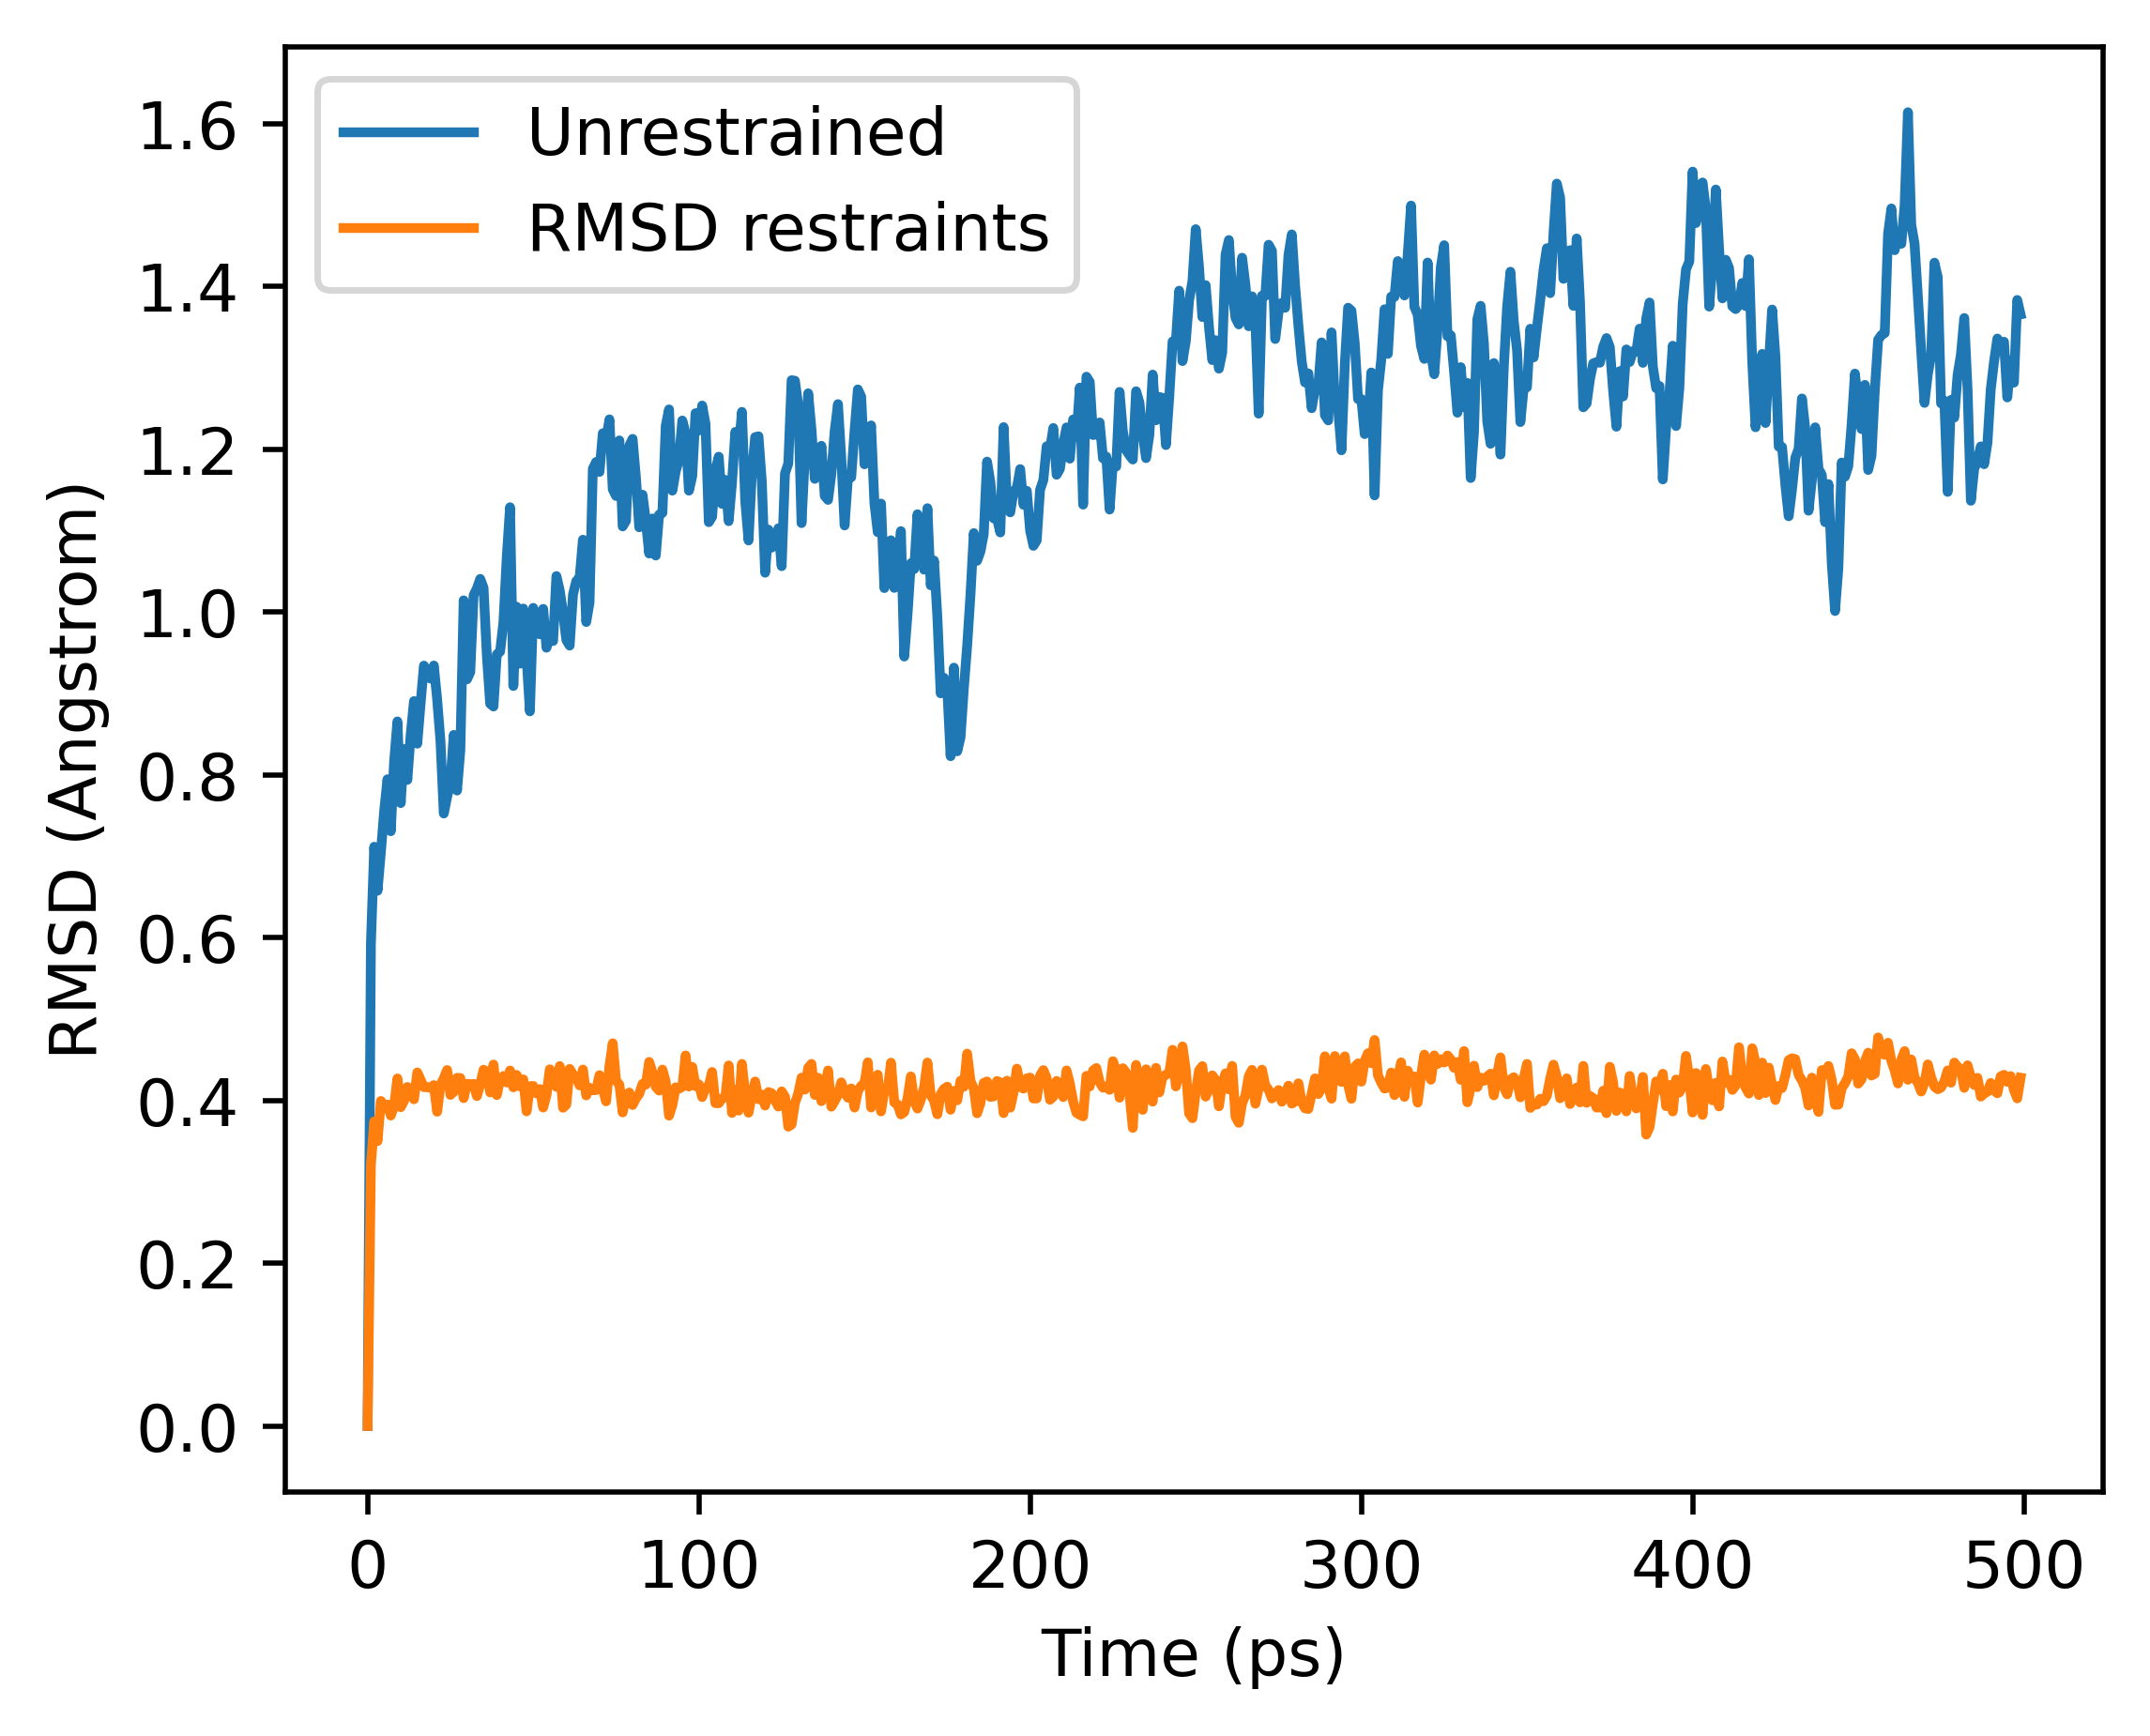

In [9]:
# Run unrestrained MD
mols = sr.load(['structures/BD2.prmtop', 'structures/BD2.inpcrd'])
mols = mols.minimisation().run().commit()
d = mols.dynamics(timestep="4fs", temperature="25oC")
d.run("500ps", "1ps")
mols = d.commit()
rmsd_unrestrained = obtain_rmsd(mols)

# Run restrained MD
mols_restr = sr.load(['structures/BD2.prmtop', 'structures/BD2.inpcrd'])
restraints = sr.restraints.rmsd(mols_restr, atoms="atomname CA, C, N", k="300 kcal mol-1 A-2")
mols_restr = mols_restr.minimisation(restraints=restraints).run().commit()
d_restr = mols_restr.dynamics(timestep="4fs", temperature="25oC", restraints=restraints)
d_restr.run("500ps", "1ps")
mols_restr = d_restr.commit()
rmsd_restrained = obtain_rmsd(mols_restr)

# Plot RMSD
plt.figure(figsize=(5,4), dpi=500)
plt.plot(rmsd_unrestrained, label='Unrestrained')
plt.plot(rmsd_restrained, label='RMSD restraints')
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (Angstrom)')
plt.legend()
plt.show()

## Testing multiple restraints

- Generate separate restraints containers for each of the regions to be restrained.
- For now, multiple restraints in a single container are not supported
- Restrain the DDB1-binding region and interface region in DCAF16 with different RMSD restraints

dynamics                  35 s  356.6 steps / s          


INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
/home/benedicttan/miniconda3/envs/openbiosim-dev/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/benedicttan/miniconda3/envs/openbiosim-dev/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


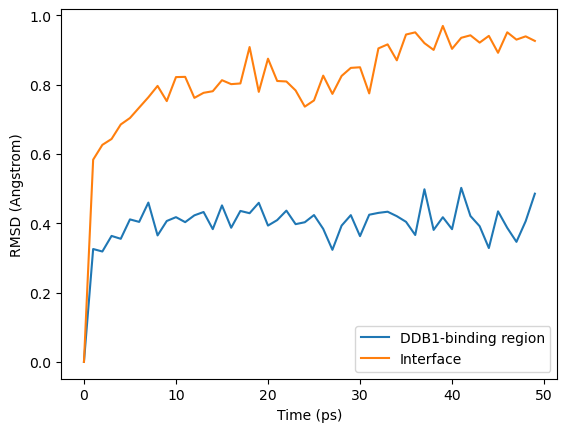

In [3]:
# Run restrained MD with DCAF16-binding restraints
mols = sr.load(['structures/DCAF16.prmtop', 'structures/DCAF16.inpcrd'])

DDB1_restraints = sr.restraints.rmsd(mols, atoms='atomname CA, C, N and resnum 70:115', k="100 kcal mol-1 A-2", name="DDB1")
RMSD_restraints = sr.restraints.rmsd(mols, atoms='atomname CA, C, N and not resnum 70:115', k="60 kcal mol-1 A-2", r0='0.5 A', name="RMSD")

mols = mols.minimisation(restraints=[DDB1_restraints, RMSD_restraints]).run().commit()
d_restr = mols.dynamics(timestep="4fs", temperature="25oC", restraints=[DDB1_restraints, RMSD_restraints])
d_restr.run("50ps", "1ps")
mols = d_restr.commit()

rmsd_DDB1 = obtain_rmsd(mols, selection_str='atomname CA, C, N and resnum 70:115')
rmsd_alch = obtain_rmsd(mols, selection_str='atomname CA, C, N and not resnum 70:115')

plt.plot(rmsd_DDB1, label='DDB1-binding region')
plt.plot(rmsd_alch, label='Interface')
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (Angstrom)')
plt.legend()
plt.show()

## Alchemical RMSD restraints

Testing RMSD restraints using lambda lever code to adjust the alchemical parameter

We can test first the expected behaviour by applying the target scaled force constant explicitely, without using the lambda schedule scaling functionality:

In [6]:
rmsd_data = {}

l_values = [0.0, 0.5, 1.0]

for lambda_value in l_values:

    mols = sr.load('structures/BD2.bss')
    mols = mols["molecule property is_perturbable"]
    mols = sr.morph.link_to_reference(mols)

    k = int(100*(1-lambda_value))

    RMSD_restraints = sr.restraints.rmsd(mols, atoms='atomname CA, C, N', k=f"{k} kcal mol-1 A-2", name="RMSD")

    mols = mols.minimisation(restraints=RMSD_restraints).run().commit()
    d = mols.dynamics(timestep="2fs", temperature="25oC", restraints=RMSD_restraints)
    
    d.randomise_velocities()
    d.run("5ps", save_frequency=0)
    d.run("50ps", "1ps")
    mols = d.commit()
    d.to_xml(f"xml_files/{lambda_value}_no_rho.xml")

    RMSD = obtain_rmsd(mols, selection_str='atomname CA, C, N')
    rmsd_data[lambda_value] = RMSD
    mols.delete_all_frames()

dynamics                  11 s 2267.8 steps / s          


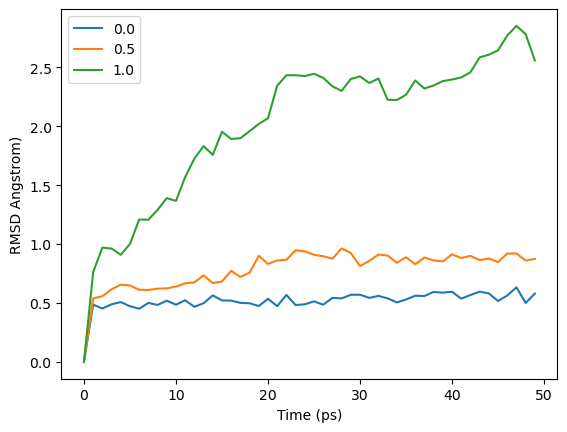

In [7]:
for l in l_values: 
    
    plt.plot(rmsd_data[l], label=l)
    
plt.ylabel('RMSD Angstrom)')
plt.xlabel('Time (ps)')
plt.legend()
plt.show()

Now we try to achieve the same force scaling using the Sire lambda-lever code:

In [14]:
mols = sr.load('structures/BD2.bss')
mols = mols["molecule property is_perturbable"]
mols = sr.morph.link_to_reference(mols)

RMSD_restraints = sr.restraints.rmsd(mols, atoms='atomname CA, C, N', k="100 kcal mol-1 A-2", name="RMSD")

# Create lambda schedule
l = sr.cas.LambdaSchedule()
l.add_stage("turn_off_rmsd_restraints", l.initial())
l.set_equation(stage="turn_off_rmsd_restraints", lever="RMSD",
               equation=1-l.lam())

rmsd_data = {} # Store sampled RMSD values

l_values = [0.0, 0.5, 1.0]

for lambda_value in l_values:

    # turn l into the lambda value by dividing by 100
    lambda_value = np.round(lambda_value, 4)
    print(f"\nSimulating lambda={lambda_value:.2f}")

    # Save starting input file
    sr.save(mols, f"traj_files/lambda{int(10*lambda_value)}", format=["prmtop", "inpcrd"])

    mols = mols.minimisation(lambda_value=lambda_value, restraints=RMSD_restraints).run().commit()
    d = mols.dynamics(timestep="2fs", temperature="25oC", restraints=RMSD_restraints, schedule=l,
                            lambda_value=lambda_value)
    
    d.randomise_velocities() 
    d.run("5ps", save_frequency=0)
    d.run("40ps", "1ps")
    mols = d.commit()

    d.to_xml(f"xml_files/{lambda_value}.xml")

    # Save to .dcd file
    sr.save(mols.trajectory(), f"traj_files/lambda{int(10*lambda_value)}", format=["DCD"])

    RMSD = obtain_rmsd(mols, selection_str='atomname CA, C, N')
    rmsd_data[lambda_value] = RMSD
    mols.delete_all_frames()

dynamics                 8.7 s 2287.5 steps / s          


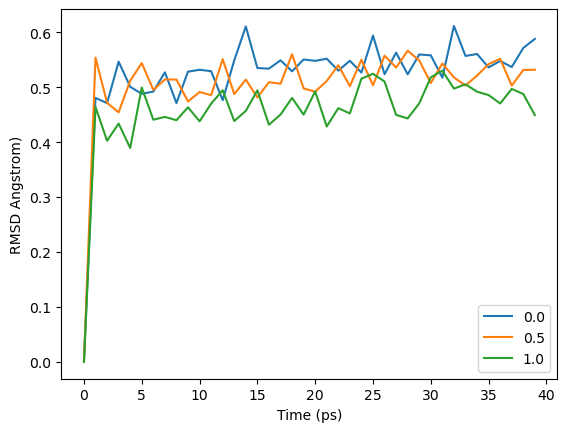

In [15]:
for l in l_values: 
    
    plt.plot(rmsd_data[l], label=l)
        
plt.ylabel('RMSD Angstrom)')
plt.xlabel('Time (ps)')
plt.legend()
plt.show()

## Calculating RMSD in MDAnalysis

/home/benedicttan/miniconda3/envs/openbiosim-dev/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/benedicttan/miniconda3/envs/openbiosim-dev/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/benedicttan/miniconda3/envs/openbiosim-dev/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn

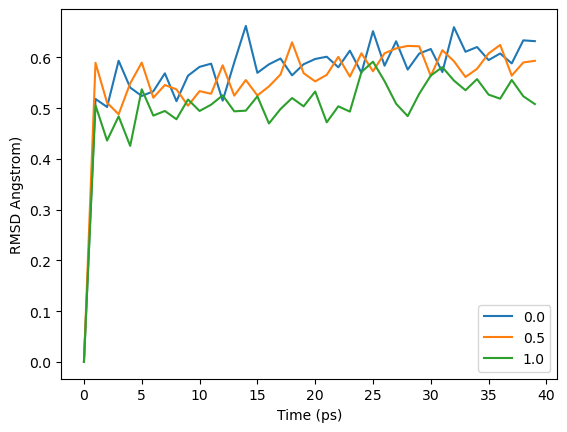

In [16]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align

def obtain_RMSD(u):
    protein = u.select_atoms("protein")

    ref = protein
    R_u =rms.RMSD(protein, ref, select=f'backbone')
    R_u.run()

    rmsd_u = R_u.rmsd.T #take transpose
    time = rmsd_u[1]/1000
    rmsd= rmsd_u[2]

    return time, rmsd

rmsd_data={}

for lmda in (0,5,10):

    u = mda.Universe(f"traj_files/lambda{lmda}.prmtop", f"traj_files/lambda{lmda}.dcd")

    time, RMSD = obtain_RMSD(u)

    rmsd_data[np.round(lmda*0.1, 3)] = RMSD

for l in (0.0, 0.5, 1.0): 
    
    plt.plot(rmsd_data[l], label=l)
        
plt.ylabel('RMSD Angstrom)')
plt.xlabel('Time (ps)')
plt.legend()
plt.show()

## Analysing OpenMM context

In [24]:
mols = sr.load('structures/BD2.bss')
mols = mols["molecule property is_perturbable"]
mols = sr.morph.link_to_reference(mols)

RMSD_restraints = sr.restraints.rmsd(mols, atoms='atomname CA, C, N', k="100 kcal mol-1 A-2", name="RMSD")

# Create lambda schedule
l = sr.cas.LambdaSchedule()
l.add_stage("turn_on_rmsd_restraints", l.initial())
l.set_equation(stage="turn_on_rmsd_restraints", lever="RMSD",
               equation=1-l.lam())

l_values = [0.0, 0.5, 1.0] # 0 means restraints fully on, 1 means restraints off

contexts = {}

for lambda_value in l_values:

    # turn l into the lambda value by dividing by 100
    lambda_value = np.round(lambda_value, 4)
    print(f"\nSimulating lambda={lambda_value:.2f}")

    mols = mols.minimisation(lambda_value=lambda_value, restraints=RMSD_restraints).run().commit()
    d = mols.dynamics(timestep="2fs", temperature="25oC", restraints=RMSD_restraints, schedule=l,
                            lambda_value=lambda_value)
    
    d.randomise_velocities() 
    d.run("5ps", save_frequency=0)
    d.run("40ps", "1ps")
    mols = d.commit()

    context = d.context()
    contexts[lambda_value] = context

    mols.delete_all_frames()

dynamics                 8.9 s 2249.7 steps / s          


In [25]:
rmsd_data = {}

for lambda_value in (0.0, 0.5, 1.0):

    print(f"Performing OpenMM simulation for lambda = {lambda_value}")

    context = contexts[lambda_value]
    system = context.getSystem()
    prmtop = app.AmberPrmtopFile(f'structures/BD2.prmtop')

    dt = 2*unit.femtoseconds 
    integrator = mm.LangevinMiddleIntegrator(300.0000*unit.kelvin, 1.0000/unit.picosecond, dt)

    simulation = app.Simulation(prmtop.topology, system, integrator)
    # simulation.reporters.append(app.StateDataReporter(stdout, 2000, step=True, time=True, speed=True))

    state = context.getState(getPositions=True, getVelocities=True)
    positions = state.getPositions()
    velocities = state.getVelocities()

    simulation.context.setPositions(positions)
    simulation.context.setVelocities(velocities)

    RMSD = []
    total_steps = 40//2E-3

    rmsd_force = system.getForce(7)
    print("\nRMSD-restraining potential:", rmsd_force.getEnergyFunction())

    # Print the global parameters
    print("\nParameters:")
    for i in range(rmsd_force.getNumGlobalParameters()):
        name = rmsd_force.getGlobalParameterName(i)
        value = rmsd_force.getGlobalParameterDefaultValue(i)
        print(f"  {name}: {value}")

    for i in range(500): # 40 ps

        simulation.step(40)
        
        RMSD.append(10*rmsd_force.getCollectiveVariableValues(simulation.context)[0])

    rmsd_data[lambda_value] = RMSD
    

Performing OpenMM simulation for lambda = 0.0

RMSD-restraining potential: rho*k_0*step(delta)*delta*delta;delta=(rmsd_0-rmsd_b_0)

Parameters:
  rho: 1.0
  k_0: 41840.0
  rmsd_b_0: 0.0
Performing OpenMM simulation for lambda = 0.5

RMSD-restraining potential: rho*k_0*step(delta)*delta*delta;delta=(rmsd_0-rmsd_b_0)

Parameters:
  rho: 0.5
  k_0: 41840.0
  rmsd_b_0: 0.0
Performing OpenMM simulation for lambda = 1.0

RMSD-restraining potential: rho*k_0*step(delta)*delta*delta;delta=(rmsd_0-rmsd_b_0)

Parameters:
  rho: 0.0
  k_0: 41840.0
  rmsd_b_0: 0.0


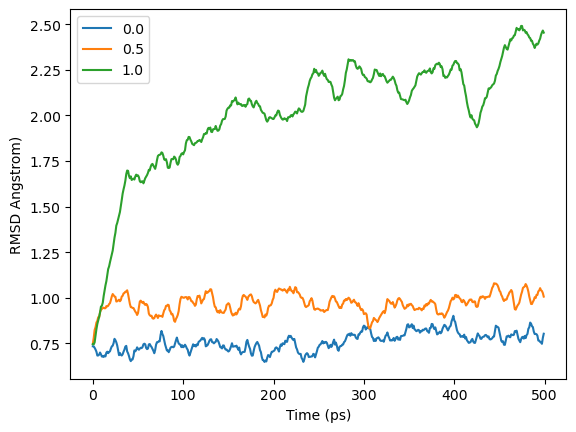

In [26]:
for l in l_values: 
    
    plt.plot(rmsd_data[l], label=l)
        
plt.ylabel('RMSD Angstrom)')
plt.xlabel('Time (ps)')
plt.legend()
plt.show()